# Dark Matter Halo Density Profile Calibration
In this notebook, we calibrate dark matter density profiles using machine learning methods. Density calibration from gravitational lensing is one of the most important problems in cluster cosmology.  Most current methods rely on analytic models (like NFW and Einasto), but these models do not capture the detailed shape of density profiles. Also, these analytic models are not able to generate error bars on predictions. 

Thus, the main objectives of this tutorial include: 
* Use neural network ensembles to better capture the complexity of density profiles and achieve more accurate density calibration. 
* Quantify prediction uncertainties (hereafter error bars). The idea is to make interval predictions rather than a single-point prediction in the case of the analytic models. This will help us capture the effect of differences in cosmology in our predictions.

We use the dimensionless peak height as opposed to using mass. This is because halo density profiles have been shown to heavily depend on peak height and also allow for the comparison of mass across redshifts. 


"Machine learning is a field of inquiry devoted to understanding and building methods that 'learn', that is, methods that leverage data to improve performance on some set of tasks. It is seen as a part of artificial intelligence. Machine learning algorithms build a model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so" ([Wikipedia](https://en.wikipedia.org/wiki/Machine_learning)).

All the machine learning algorithms considered in this notebook are supervised and our outcome variable is continuous. By supervised machine learning we mean there are labeled outcomes that we want to predict using other features in the data set. Unsupervised machine learning has no labeled outcomes. Hence, the idea is to learn patterns in a data set as well as learn the relationship between the features - without any labels. A typical application of unsupervised machine learning is dimensionality reduction. Sometimes, the results from an unsupervised machine learning model are used as input for other models.


## Packages

In [1]:
#-------------importing libraries
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_uncertainty
from sklearn import metrics
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from colossus.cosmology import cosmology
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from keras_uncertainty.models import DeepEnsembleRegressor
from keras_uncertainty.losses import regression_gaussian_nll_loss
from tensorflow.python.framework.ops import disable_eager_execution
from colossus.halo import profile_nfw, profile_dk14, profile_einasto
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from tensorflow.keras.optimizers import SGD, Adam, Nadam, RMSprop, Adadelta, Adagrad, Adamax, Ftrl

plt.style.use("CustomizingPlots")

2022-09-22 02:01:32.052991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/openmpi3/gcc/3.1.3/lib:/cm/shared/apps/nccl2-cuda10.2-gcc8/2.8.4/lib:/cm/shared/apps/cudnn7.6-cuda10.2/7.6.5.32/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda10.2/toolkit/10.2.89/targets/x86_64-linux/lib:/cm/local/apps/python37/lib:/cm/shared/apps/gcc8/8.4.0/lib:/cm/shared/apps/gcc8/8.4.0/lib32:/cm/shared/apps/gcc8/8.4.0/lib64:/cm/shared/apps/hdf5_18/1.8.18-mpi/lib:/cm/shared/apps/openblas/0.2.20/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-09-22 02:01:32.053026: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Keras Uncertainty will use standalone Keras backend

<!-- Setting working directory to the directory containing the data -->

## Loading data
We load in 3 different data sets.

* `BigData_PH2.csv`: Contains data for the radial bins.
* `BigRockstar_PH2.csv`: This data contains the halo properties of all the halos in our catalog.

The two data sets above contain all the information that will be supplied to the analytic models that will be fitted in this notebook.
* `BigData_PH2.csv`: Contains the data prepared for the machine learning models.

`BigRockstar_PH2.csv` and `BigData_PH2.csv` contain the same set of halos. All data were cleaned in a separate jupyter notebook file.

In [2]:
Final_DF_Log = pd.read_csv("Data/Data_PH_new.csv")
radial_bins_3d = pd.read_csv("Data/radial_bins.csv")
rockstar_rs_z_final = pd.read_csv("Data/Rockstar_PH_new.csv")
Final_DF_Log["index"] = Final_DF_Log.index #This column will be useful later
print("Shape of data", Final_DF_Log.shape)
Final_DF_Log.head()

Shape of data (11167964, 13)


,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys,id,index
0,0.798146,36.474184,-2.877325,6.513000e+13,0.606208,0.053348,0.077629,0.56353,6.926866e+15,2.221418,0.034120,28018334,0
1,0.798146,36.571866,-2.647067,6.513000e+13,0.606208,0.067162,0.077629,0.56353,7.637651e+15,2.221418,0.042955,28018334,1
2,0.798146,36.048141,-2.416808,6.513000e+13,0.606208,0.084552,0.077629,0.56353,4.523858e+15,2.221418,0.054077,28018334,2
3,0.798146,35.095003,-2.186550,6.513000e+13,0.606208,0.106444,0.077629,0.56353,1.744079e+15,2.221418,0.068079,28018334,3
4,0.798146,35.146164,-1.956292,6.513000e+13,0.606208,0.134005,0.077629,0.56353,1.835630e+15,2.221418,0.085707,28018334,4


## Test halos: Selecting halos for further comparison
Here, we randomly select some halos, which will be used to test our models later. The halos selected are set aside and then removed from our data set. This is to make sure that these halos are used only for testing. Thus, they must not be involved in any part of our modeling process. One halo is carefully selected from the data while the rest are chosen randomly. 


For some halos, some radial bins were dropped because they have zero densities at those radial bins. Hence, those halos have less than 18 radial bins and it is difficult to know which radial bin has been dropped, Here we want to make sure all the halos selected have 18 radial bins for easy plotting.


In [3]:
halo1_id = 21771717 
n = 3

while True:
    halo_ids = random.sample(list(np.unique(Final_DF_Log["id"])), n)
    if len(Final_DF_Log[Final_DF_Log["id"] == halo_ids[0]]) == 18 and \
    len(Final_DF_Log[Final_DF_Log["id"] == halo_ids[1]]) == 18 and \
    len(Final_DF_Log[Final_DF_Log["id"] == halo_ids[2]]) == 18:
        break
    
halo_ids.append(halo1_id)
print(halo_ids)

[19456758, 17942897, 23564476, 21771717]


In [4]:
test_halo1 = Final_DF_Log[Final_DF_Log["id"] == halo1_id]#.iloc[20:, ] #Set aside first halo
test_halo2 = Final_DF_Log[Final_DF_Log["id"] == halo_ids[0]] #Set aside second halo
test_halo3 = Final_DF_Log[Final_DF_Log["id"] == halo_ids[1]] #Set aside third halo
test_halo4 = Final_DF_Log[Final_DF_Log["id"] == halo_ids[2]] #Set aside fourth halo
print(test_halo1.shape[0] == 18)
print(test_halo2.shape[0] == 18)
print(test_halo3.shape[0] == 18)
print(test_halo4.shape[0] == 18)
test_halo1.head()

True
True
True
True


,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys,id,index
41366,1.114647,35.901513,-3.451394,3.944000e+14,1.209305,0.053348,0.169418,0.391576,3.906869e+15,3.048493,0.038337,21771717,41366
41367,1.114647,35.903883,-3.221136,3.944000e+14,1.209305,0.067162,0.169418,0.391576,3.916139e+15,3.048493,0.048263,21771717,41367
41368,1.114647,35.772720,-2.990877,3.944000e+14,1.209305,0.084552,0.169418,0.391576,3.434747e+15,3.048493,0.060760,21771717,41368
41369,1.114647,35.438623,-2.760619,3.944000e+14,1.209305,0.106444,0.169418,0.391576,2.459226e+15,3.048493,0.076492,21771717,41369
41370,1.114647,35.084319,-2.530361,3.944000e+14,1.209305,0.134005,0.169418,0.391576,1.725544e+15,3.048493,0.096297,21771717,41370


In [5]:
Final_DF_Log = Final_DF_Log[Final_DF_Log["id"] != halo1_id] #Eliminate first halo from data
Final_DF_Log = Final_DF_Log[Final_DF_Log["id"] != halo_ids[0]] #Eliminate second halo from data
Final_DF_Log = Final_DF_Log[Final_DF_Log["id"] != halo_ids[1]] #Eliminate third halo from data
Final_DF_Log = Final_DF_Log[Final_DF_Log["id"] != halo_ids[2]] #Eliminate fourth halo from data
Final_DF_Log[["Mvir_Msun.h", "rmid_Rvir", "Density"]].head()

,Mvir_Msun.h,rmid_Rvir,Density
0,6.513000e+13,-2.877325,36.474184
1,6.513000e+13,-2.647067,36.571866
2,6.513000e+13,-2.416808,36.048141
3,6.513000e+13,-2.186550,35.095003
4,6.513000e+13,-1.956292,35.146164


After removing the halos from the data set, we check to see if those halos were actually elimated from the data. Below we search for the halos IDs to make sure they are not in the data.

In [6]:
for i in halo_ids:
    if i in list(Final_DF_Log["id"]):
        print(i, "found")
    else:
        print(i, "not found")

19456758 not found
17942897 not found
23564476 not found
21771717 not found


## Reshuffling the data

The data set is arranged according to radial bins and halo IDs. Also, high-mass halos come before low-mass halos. Hence, we shuffle the data to prevent the machine learning models from learning these spurious patterns in the data.

In [7]:
Final_DF_Log_reshuffle = shuffle(Final_DF_Log, random_state=0)
Final_DF_Log_reshuffle.head()

,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys,id,index
4208942,0.666532,33.791058,-1.246419,3.037000e+13,0.460720,0.212384,0.094583,0.603235,4.734455e+14,1.947471,0.132472,9707166,4208942
1231615,0.777353,28.832196,0.684762,4.532000e+13,0.508617,1.687020,0.114735,0.672405,3.324020e+12,2.175706,1.008739,33265042,1231615
913928,0.882409,33.727244,-1.361463,8.494000e+13,0.642285,0.267375,0.220210,0.624311,4.441768e+14,2.416715,0.164608,12227803,913928
9889835,0.339275,31.051617,-0.409251,1.132000e+13,0.387639,0.336606,0.054471,0.307463,3.058762e+13,1.403929,0.257450,11299970,9889835
9324663,0.320624,27.053077,1.468183,1.018000e+13,0.374205,2.123840,0.037611,0.307340,5.610505e+11,1.377987,1.624551,10750913,9324663


## Train-test split

We split the data into an 80\% training set and a 20\% testing set. We train the models to predict the outcome variable using the test data. During training, the models are expected to learn patterns in the data such as the relationship between the input variables and outcome variable. We then test the models' ability to generalize what they learned to completely unseen data (test set). By unseen data, we mean data that has not been revealed to the models by any means. This is how we test the models' ability to perform in the real world.

Note that the outcome variable `Density` is actually the logarithm of the densities. This is to reduce the spread of it. Thus, we will train our machine learning models to predict log densities instead of the raw density values.



In [8]:
#-------------Separate Target Variable and Predictor Variables
TargetVar=["Density"]
X = Final_DF_Log_reshuffle#.values
y = Final_DF_Log_reshuffle[TargetVar]#.values


#-------------Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Data visualization and descriptive statistics

Data visualization and description are necessary to give us first-hand information about the features in the data set, such as the distribution of the features as well as the relationship between the features. We do so on the training data. The data contain the original values of the mass and virial radius. Hence, we take log of them for the purpose of visualization.

### Box plot of variables



In [9]:
data = X_train
data[["Mvir_Msun.h", "Rvir_Mpc.h"]] = np.log(X_train[["Mvir_Msun.h", "Rvir_Mpc.h"]])

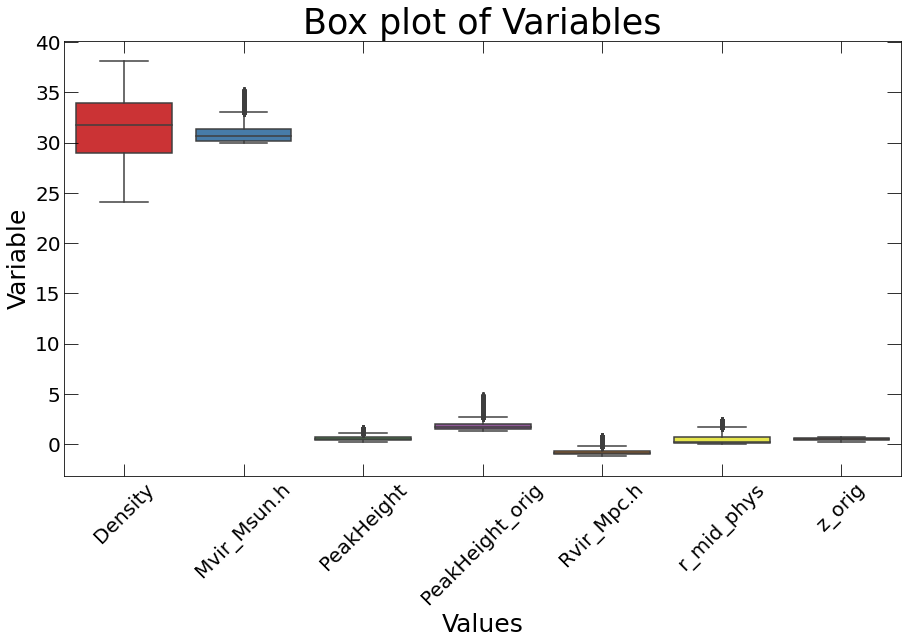

In [10]:
plt.figure(figsize = (15,8))
sns.boxplot(data = data[["Density", "Mvir_Msun.h","PeakHeight", 
                         "PeakHeight_orig", "Rvir_Mpc.h", 
                         "r_mid_phys", "z_orig"]], palette="Set1")
plt.xlabel("Values")
plt.ylabel("Variable")
plt.xticks(rotation = 45)
plt.title("Box plot of Variables")
plt.show()

### Pair plot 

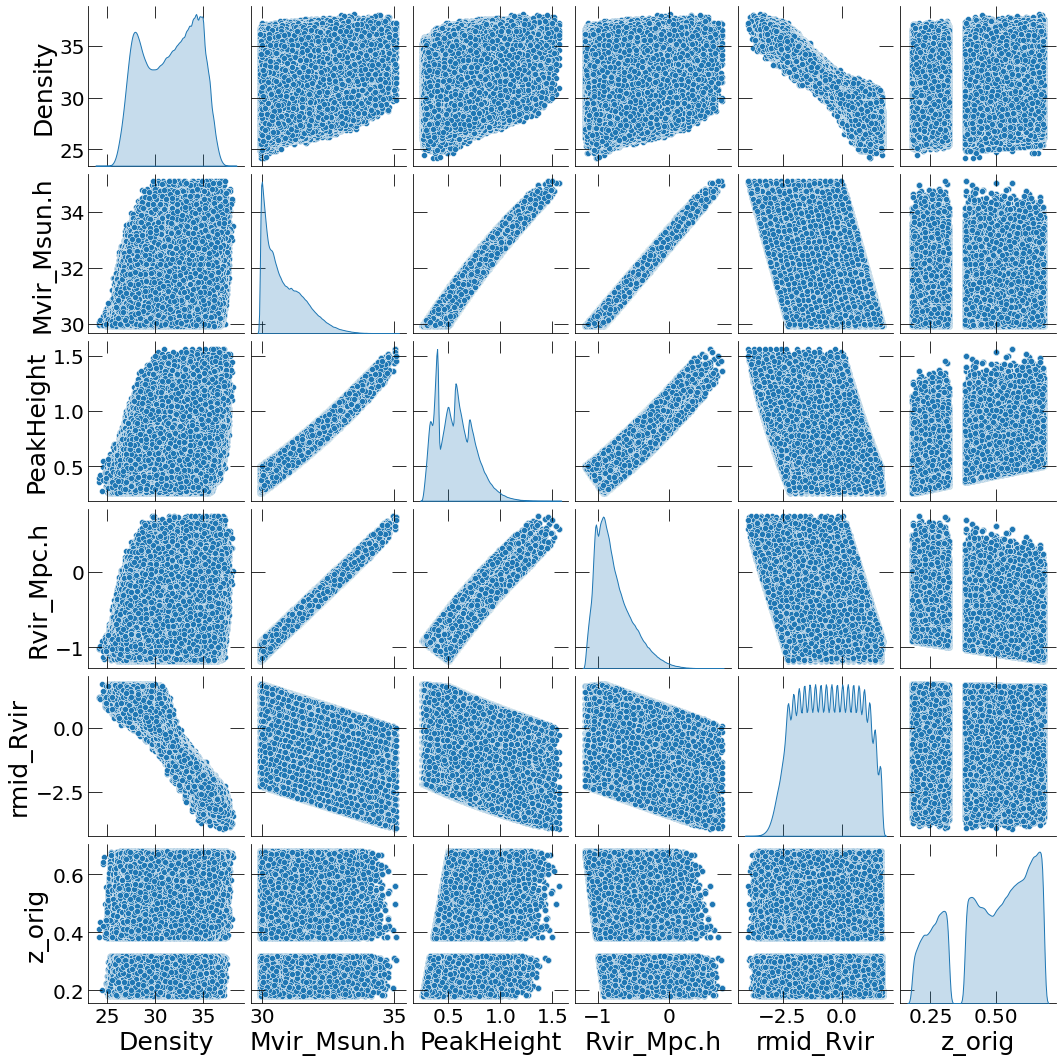

In [11]:
sns.pairplot(data[["Density", "Mvir_Msun.h","PeakHeight", "Rvir_Mpc.h", 
                         "rmid_Rvir", "z_orig"]], diag_kind='kde')
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=12, top = True, right = True, rotation = 45)
plt.xlabel(" ", fontsize=20)
plt.xticks(rotation = 90)
plt.show()

### Descriptive statistics

In [12]:
X_train.drop(["id", "index"], axis = 1).describe()

,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys
count,8.934313e+06,8.934313e+06,8.934313e+06,8.934313e+06,8.934313e+06,8.934313e+06,8.934313e+06,8.934313e+06,8.934313e+06,8.934313e+06,8.934313e+06
mean,5.677359e-01,3.149459e+01,-5.483906e-01,3.082717e+01,-7.805506e-01,7.213934e-01,1.111064e-01,4.765742e-01,5.405036e+14,1.793559e+00,4.932167e-01
std,1.785644e-01,2.768124e+00,1.212786e+00,7.709524e-01,2.527563e-01,7.571780e-01,8.321464e-02,1.449327e-01,1.147137e+15,3.385339e-01,5.228787e-01
min,2.534222e-01,2.413369e+01,-3.946269e+00,2.993461e+01,-1.181155e+00,5.334840e-02,1.027700e-02,1.800000e-01,3.027816e+10,1.288427e+00,3.175500e-02
25%,4.051401e-01,2.898968e+01,-1.567644e+00,3.018281e+01,-9.684620e-01,1.340050e-01,5.869258e-02,3.870820e-01,3.890976e+12,1.499513e+00,9.545977e-02
50%,5.603915e-01,3.172883e+01,-5.403943e-01,3.060910e+01,-8.405652e-01,4.237610e-01,8.555724e-02,5.023170e-01,6.020839e+13,1.751358e+00,2.654614e-01
75%,6.943723e-01,3.390884e+01,4.803778e-01,3.132364e+01,-6.431168e-01,1.064440e+00,1.330573e-01,6.025230e-01,5.326271e+14,2.002452e+00,7.253914e-01
max,1.564129e+00,3.813526e+01,1.735013e+00,3.508284e+01,7.333529e-01,2.673750e+00,1.608184e+00,6.800000e-01,3.646979e+16,4.778513e+00,2.265886e+00


## Error bars from actual data

The original data do not have error bars. However, we want to have an estimate of the error bars. Hence, for each radial bin, the error bar is computed as the standard deviation of all the densities in that bin.

In [13]:
#-------------Error bars from actual data
actual_err_bars = X_train[["r_mid", "Density"]].groupby(["r_mid"]).std().values.ravel()#.reshape(1,-1)[0]
actual_err_bars

array([0.65203292, 0.69381139, 0.71449099, 0.71372079, 0.70573067,
       0.71009755, 0.72093202, 0.73844003, 0.76347801, 0.80078033,
       0.86669143, 0.94023981, 1.01050564, 1.02537214, 0.96346013,
       0.87566343, 0.81032258, 0.76280613])

## Data standardization
Data standardization is important to allow machine learning models to learn well. The idea is to bring all features to a common scale. If the features are on different scales, those having higher scales might dominate the rest. This leads to a loss of information in modeling. We can avoid this by standardizing the data. After standardization, all the features become independent of their units of measurement.

We tried several standardization techniques but the `MaxAbsScaler` yields the best performance. We split the data before applying the scaler to avoid cheating. By cheating, we mean leaking some information in the testing data to the models before testing the models on it. The testing data is supposed to be totally unseen by the models before testing. If we scale the data before splitting, then the models will have access to important information in the test set before they are tested on it. In this case, it means we are technically training the models on both training and testing sets. This will limit our ability to test how the models actually generalize/perform in the real world.


In [14]:
X_test_actual = pd.DataFrame(X_test)  # Keeping a copy of X test data before tranforming it. 
                                      # This will be needs later
    
y_test_actual = y_test.values.ravel() # Keeping a copy of y test data before transforming it. 
                                      # This will be used to compare predictions.
    
X_train = pd.DataFrame(X_train)[["PeakHeight", "rmid_Rvir"]].values
X_test = pd.DataFrame(X_test)[["PeakHeight", "rmid_Rvir"]].values

#-------------Standardization of data
PredictorScaler=MaxAbsScaler()
TargetVarScaler=MaxAbsScaler()

# PredictorScaler=RobustScaler()
# TargetVarScaler=RobustScaler()

# PredictorScaler=StandardScaler()
# TargetVarScaler=StandardScaler()

# PredictorScaler=MinMaxScaler()
# TargetVarScaler=MinMaxScaler()

#-------------Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X_train)
TargetVarScalerFit=TargetVarScaler.fit(y_train)

#-------------Generating the standardized values of X and y
X_train=PredictorScalerFit.transform(X_train)
X_test=PredictorScalerFit.transform(X_test)
y_train=TargetVarScalerFit.transform(y_train)
y_test=TargetVarScalerFit.transform(y_test)


#-------------Quick sanity check with the shapes of Training and testing datasets
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (8934313, 2)
y_train (8934313, 1)
X_test (2233579, 2)
y_test (2233579, 1)


## Preparing test halos

Here, we apply the scaler in the above cell to transform the data for the test halos.

In [15]:
Test_halo_target=["Density"]

#-------------First test halo
X_test_halo1 = test_halo1[["PeakHeight", "rmid_Rvir"]].values
y_test_halo1 = test_halo1[Test_halo_target].values.ravel()#.reshape(1,-1)[0]

#-------------Second test halo
X_test_halo2 = test_halo2[["PeakHeight", "rmid_Rvir"]].values
y_test_halo2 = test_halo2[Test_halo_target].values.ravel()#.reshape(1,-1)[0]

#-------------Third test halo
X_test_halo3 = test_halo3[["PeakHeight", "rmid_Rvir"]].values
y_test_halo3 = test_halo3[Test_halo_target].values.ravel()#.reshape(1,-1)[0]

#-------------Fourth test halo
X_test_halo4 = test_halo4[["PeakHeight", "rmid_Rvir"]].values
y_test_halo4 = test_halo4[Test_halo_target].values.ravel()#.reshape(1,-1)[0]

#-------------Standardizing the values of the test halos
X_test_halo1=PredictorScalerFit.transform(X_test_halo1)
X_test_halo2=PredictorScalerFit.transform(X_test_halo2)
X_test_halo3=PredictorScalerFit.transform(X_test_halo3)
X_test_halo4=PredictorScalerFit.transform(X_test_halo4)

# #-------------Turning the data into appropriate format and picking only the needed columns
# X_test_halo1=pd.DataFrame(X_test_halo1).values
# X_test_halo2=pd.DataFrame(X_test_halo2).values
# X_test_halo3=pd.DataFrame(X_test_halo3).values
# X_test_halo4=pd.DataFrame(X_test_halo4).values

print(X_test_halo1.shape)
print(y_test_halo1.shape)
print(X_test_halo2.shape)
print(y_test_halo2.shape)
print(X_test_halo3.shape)
print(y_test_halo3.shape)
print(X_test_halo4.shape)
print(y_test_halo4.shape)

(18, 2)
(18,)
(18, 2)
(18,)
(18, 2)
(18,)
(18, 2)
(18,)


# Neural network methodology

The idea behind neural network algorithms mimics how biological neurons in the human brain function. They consist of a series of artificial units or nodes called neurons. A neural network typically consists of 3 layers, as given below. Each layer is made up of nodes/neurons.
* Input layers - this essentially consists of input features. Thus, the number of input nodes is the same as the number of input variables 
* Hidden layer - it connects the input layer to the output layer. Unlike in Fig. 1 below, we can have more than 1 hidden layer. If a network has more than 1 hidden layer it is called a **deep neural network.**
* Output layer - this layer produces the final output of the model. Again, unlike in Fig. 1 below, a neural network model may have multiple nodes in the output layer depending on the problem. Classification problems typically have multiple nodes in the output layer. A regression problem will have a single node in the output layer.

A neural network has only 1 layer for inputs and outputs. Also, the number of nodes in the input and output layers is usually known in advance. However, the number of hidden layers as well as the number of nodes in each hidden layer cannot be readily determined in advance. It often depends on the complexity of the data to be learned and the activation function used. Their configuration must be chosen carefully to avoid overfitting. Also, note that increasing the number of hidden layers and hidden nodes increases the model's complexity and training time. There is no single universally accepted rule-of-thump to determine the number of hidden layers and hidden nodes. One popular approach is to adopt cross-validation. See this article on [medium](https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3) for more on this subject. Also, see this blog post on [machine learning mastery](https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/).


Neural networks are generally seen as **black box** algorithms but they are theoretically and mathematically well grounded. A lot of research is still being conducted to better understand them and improve their performance. Neural networks are widely used because they are universal approximators with great predictive capabilities. They are able to learn from complex relationships between inputs and the outcome variable. **A neural network with no hidden layer is simply a linear regression model.** For supervised machine learning problems, the idea is to learn the weights and biases from the data using the relationship between the inputs and the outcome variable. Sometimes, the relationship between the inputs and the outcome variable can be very complex. The process of learning the model weights and biases is called training. During training, information is carried from one layer to the other through activation functions. These activation functions are what introduce non-linearity into neural networks. Activation functions are able to take in a linear function so that the output of that linear function can be modeled in a non-linear manner. However, it is good to note that not all activation functions are non-linear. We use activation functions to define the output of a node. Popular activation functions available in the literature include sigmoid, softmax, relu, and leaky relu. To read more on activation functions, check this article on [medium](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6). Also, see this blog post on [machine learning mastery](https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/#:~:text=An%20activation%20function%20in%20a,a%20layer%20of%20the%20network.). The architecture of a single layer perceptron model shown in Fig. 1 below.

| <img src="images/NN3.png" alt="drawing" width="70%"/> |
|:--:|
| Fig.1 - *Left*: The structure of a typical biological neuron. *Right*: Artificial neural network. A perceptron with a single hidden layer. This is a fully connected perceptron - each node in a layer is connected to any other node in the next layer. The activation function is denoted by $f$. The sum of the products of weights and input features plus the bias term are fed into the activation function to produce the output of the model.  Credit: [ACS Solutions](https://acsicorp.com/blogs/fundamentals-artificial-neural-networks-are-to-deep-learning-what-atoms-are-to-matter/)|


## Uncertainty quantification
Deep neural networks are popular due to their predictive capabilities but quantifying the reliability of their predictions still remains an active area of research. Uncertainty quantification techniques help to measure a model's confidence in its predictions. We expect the measure of uncertainty to be low when the model's level of confidence about its prediction is high and vice versa. In regression base ensemble methods, it is a common practice to use the mean and variance/spread as prediction and measure of uncertainty, respectively. For classification problems, one way is to allow the models in the ensemble to vote and the class with the majority votes wins. Entropy and max-probability are the most popular uncertainty measures for classification ensembles ([Durasov et al., 2020](https://ui.adsabs.harvard.edu/abs/2020arXiv201208334D/abstract)). In this tutorial, we adopt two machine learning popular uncertainty quantification techniques. They are Deep ensembles and Monte Carlo dropouts. In uncertainty quantification, the general intuition is to build an army of models whose aggregate performance is significantly better than any of the models in isolation. We can estimate uncertainty from the aggregate results of the ensemble. 


Some uncertainty quantification techniques include:
* Monte Carlo Dropout 
* Deep Ensembles
* Bayesian Neural Network
* Masksembles
* Batchensemble  
* Random Forest

This notebook covers only the first two models in the list above. Note that the list of models is not limited to the one above.

Below are some of the types of uncertainty that can affect predictions.

* **Aleatoric uncertainty**: Also known as data uncertainty, captures noise that arises from data and therefore is irreducible because the natural complexity of the data directly causes it. 
* **Epistemic uncertainty**: Also known as model uncertainty. It accounts for uncertainty in the parameters of the model that we learned. Hence, it represents our ignorance about the parameters of the data generation process. It is reducible. Given enough data, epistemic uncertainty could be eliminated entirely.
* **Distributional uncertainty**: Also known as dataset shift. This type of uncertainty arises when there is a mismatch between the training and testing data distributions, and a model is confronted with unfamiliar samples.



## Monte Carlo Dropout (MCD)

Originally, MCD (or simply dropout) is a regularization technique but this method now serves as a deep learning ensemble technique. The basic idea is to randomly drop a percentage of neurons at each layer for every pass during training ([Hinton et al., 2012](https://ui.adsabs.harvard.edu/abs/2012arXiv1207.0580H)). However, [Gal \& Ghahramani (2016)](https://ui.adsabs.harvard.edu/abs/2015arXiv150602142G) show that using dropout at inference time is a useful way to quantify prediction uncertainties. They introduce the theoretical and mathematical framework for MCD as approximate Bayesian inference in deep Gaussian processes --- thus, training
a dropout network mathematically converges to Bayesian inference. Also, this approximation serves as a useful alternative to Bayesian models that offer a framework that is mathematically robust in quantifying model uncertainties but are rather computationally expensive. A major thing to consider in MCD is the percentage of neurons to drop. [Srivastava et al. (2014)](https://jmlr.org/papers/v15/srivastava14a.html) provide several experimental results and gave some useful heuristics about the dropout technique. Thus, MCD trains just a single stochastic network but achieves randomness by randomly eliminating a different set of neurons several times. Doing this during testing results in correlated models. The MCD model architecture is illustrated in the figure below.

<!-- ![MCD_image2.jpg](images/MCD_image2.jpg) -->

<!-- <img src="images/MCD_image2.jpg" alt="drawing" width="50%"/> -->

<!-- <figure>
<img src="images/MCD_image2.jpg" alt="drawing" width="50%"/>
<figcaption align = "center">Fig.1 - 4K Mountains Wallpaper</figcaption>
</figure> -->



<!-- ![MCD_image2.jpg](attachment:MCD_image2.jpg) -->

| <img src="images/MCD_image2.jpg" alt="drawing" width="60%"/> |
|:--:|
| Fig.2 - Illustration of MCD. The Figure shows a fully connected neural network model (top) and networks with some nodes switched off (bottom). In this diagram, the red nodes were randomly switched off. Hence, they do not receive any information from the nodes in the previous layer(s).  They do not transmit any information to the nodes in the subsequent layer(s) as well. Their contribution is entirely eliminated from the network and this is represented by the gray lines entering or going out from these switched-off nodes. Here, we train a single neural network architecture and then randomly switch off a fraction of the nodes several times and use it to make predictions each time. Thus, we can use the single trained neural network model to make an infinite number of predictions. We can form a distribution from all the predictions for a certain observation from which we obtain the aggregate prediction of the ensemble. MCD results in a correlated set of models. Thus, every two models share a fraction of set of their parameters/weights.|



Note that we fit the model with the optimal parameters identified straight away. For instance, tried several activation functions and the `leaky_relu` activation function is the best. We also followed the heuristics presented in [Srivastava et al. (2014)](https://jmlr.org/papers/v15/srivastava14a.html), to select an optimal dropout rate.


### Model fitting (MCD)

In [16]:
%%time

model_mcd = tf.keras.models.Sequential()

#-------------Input layer
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.5)
model_mcd.add(tf.keras.layers.Dense(8, input_dim=2, 
                                    kernel_initializer='he_uniform', 
                                    activation=leaky_relu))

model_mcd.add(tf.keras.layers.Dropout(0.55)) #Dropping 55% of neurons
model_mcd.add(tf.keras.layers.Dense(16, kernel_initializer='he_uniform', 
                             activation=leaky_relu))
model_mcd.add(tf.keras.layers.Dropout(0.55)) #Dropping 55% of neurons
model_mcd.add(tf.keras.layers.Dense(16, kernel_initializer='he_uniform', 
                             activation=leaky_relu))
#-------------The output layer
model_mcd.add(tf.keras.layers.Dense(1, kernel_initializer='he_uniform', 
                             activation=leaky_relu))

#-------------Optimizer
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model_mcd.compile(loss="mse", optimizer=optimizer)

#-------------Fit model
hist = model_mcd.fit(X_train, y_train, batch_size=3000, 
                     epochs=50, validation_split=0.2, verbose=0)

2022-09-22 02:13:01.061998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/openmpi3/gcc/3.1.3/lib:/cm/shared/apps/nccl2-cuda10.2-gcc8/2.8.4/lib:/cm/shared/apps/cudnn7.6-cuda10.2/7.6.5.32/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda10.2/toolkit/10.2.89/targets/x86_64-linux/lib:/cm/local/apps/python37/lib:/cm/shared/apps/gcc8/8.4.0/lib:/cm/shared/apps/gcc8/8.4.0/lib32:/cm/shared/apps/gcc8/8.4.0/lib64:/cm/shared/apps/hdf5_18/1.8.18-mpi/lib:/cm/shared/apps/openblas/0.2.20/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-09-22 02:13:01.062038: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 02:13:01.062065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to 

CPU times: user 9min 17s, sys: 57.7 s, total: 10min 15s
Wall time: 4min 55s


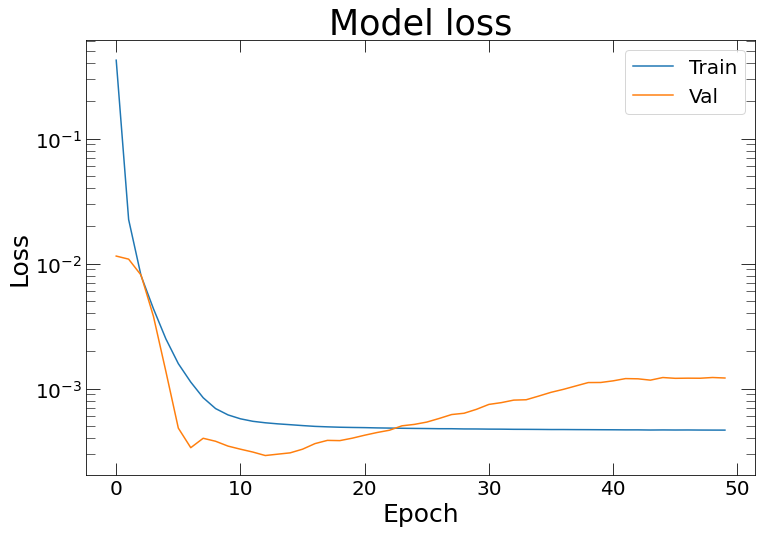

In [17]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.yscale("log")
plt.show()

### Model summary

In [18]:
#-------------Model summary
model_mcd.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 24        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 457
Trainable params: 457
Non-trainable pa

### Computing error bars on predictions

The functions below take the dropout model, make several predictions with it for each data point, and then return the mean of the predictions as the final prediction for all the data points. We will make 50 predictions for each data point.


In [19]:
class MonteCarloDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


#-------------Distribution of predictions
def predict_dist(X, saved_model, num_samples):
    '''
    #----------Arguments/Inputs:
        X: The input 
        saved_model: The dropout model
        num_samples: Number of predictions to make
    
    #----------Output(s):
        Returns all model predictions as a numpy array
    '''
    preds = [saved_model(X, training=True) for _ in range(num_samples)]
    return np.hstack(preds)

#-------------Distribution and Mean of predictions
def predict_point(X, saved_model, num_samples):
    '''
    #----------Arguments/Inputs::
        X: The input 
        saved_model: The dropout model
        num_samples: Number of predictions to make
    #----------Output(s):
        Returns the mean and distribution of predictions
    '''
    pred_dist = predict_dist(X, saved_model, num_samples)
    return pred_dist.mean(axis=1), pred_dist
    #return stats.mode(pred_dist), pred_dist

In [20]:
%%time
n = 50 #number of predictions to make
y_pred_dist = predict_dist(X_test, model_mcd, n)
y_pred_mcd = predict_point(X_test, model_mcd, n)

CPU times: user 2min 5s, sys: 3min 2s, total: 5min 8s
Wall time: 31.4 s


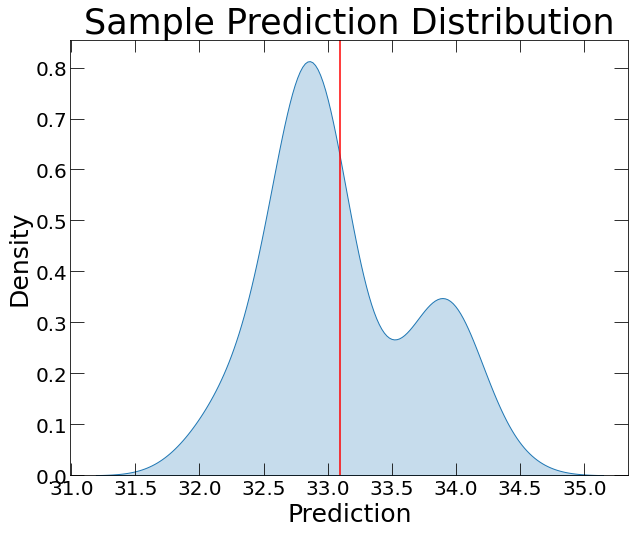

In [21]:
plt.figure(figsize=(10,8))
sns.kdeplot(TargetVarScaler.inverse_transform(y_pred_mcd[1])[30], shade=True)
plt.axvline(TargetVarScaler.inverse_transform((y_pred_mcd[0])[30].reshape(1, -1)), color='red')
plt.xlabel("Prediction")
plt.ylabel("Density")
plt.title("Sample Prediction Distribution")
plt.show()

## Inverse tranform predictions 
We then inverse transform the predictions to their actual values.


In [22]:
Actual_predictions_mcd = TargetVarScaler.inverse_transform(y_pred_mcd[0].reshape(1, -1))[0]
Actual_predictions_mcd

array([27.729174, 33.347477, 27.877121, ..., 34.533524, 28.328348,
       28.343166], dtype=float32)

## Computing MCD error bars
For each radial bin, the error bar is computed as the standard deviation of all predictions for that data point.

In [23]:
err_bars_mcd = y_pred_mcd[1].std(axis = 1)
pred_err_bars_mcd = TargetVarScaler.inverse_transform(err_bars_mcd.reshape(1, -1))[0]
pred_err_bars_mcd

array([0.5551977 , 0.58640456, 0.3535778 , ..., 0.43346903, 0.3626443 ,
       0.52652377], dtype=float32)

### Test halo prediction (MCD)

We will now use the dropout model to make 50 predictions for the test halos. Again, the mean of the predictions is taken as the final prediction.


In [24]:
#-------------First halo
test_halo_predictions1_mcd = predict_point(X_test_halo1, model_mcd, 50) 
test_halo_pred1_mcd = TargetVarScaler.inverse_transform(test_halo_predictions1_mcd[0]\
                                                        .reshape(1, -1))[0]

#-------------Second halo
test_halo_predictions2_mcd = predict_point(X_test_halo2, model_mcd, 50)
test_halo_pred2_mcd = TargetVarScaler.inverse_transform(test_halo_predictions2_mcd[0]\
                                                        .reshape(1, -1))[0]

#-------------Third halo
test_halo_predictions3_mcd = predict_point(X_test_halo3, model_mcd, 50)
test_halo_pred3_mcd = TargetVarScaler.inverse_transform(test_halo_predictions3_mcd[0]\
                                                        .reshape(1, -1))[0]

#-------------Fourth halo
test_halo_predictions4_mcd = predict_point(X_test_halo4, model_mcd, 50)
test_halo_pred4_mcd = TargetVarScaler.inverse_transform(test_halo_predictions4_mcd[0]\
                                                        .reshape(1, -1))[0]

### Error bars for test halo predictions (MCD)
Again, for each data point, the error bar is computed as the standard deviation of all predictions for that data point.


In [25]:
#-------------Error bars on test halos (MCD)
err_bars11 = test_halo_predictions1_mcd[1].std(axis = 1) #First halo
err_bars22 = test_halo_predictions2_mcd[1].std(axis = 1) #Second halo
err_bars33 = test_halo_predictions3_mcd[1].std(axis = 1) #Third halo
err_bars44 = test_halo_predictions4_mcd[1].std(axis = 1) #Fourth halo

#-------------Inverse transform error bars
err_bars1_mcd = TargetVarScaler.inverse_transform(err_bars11.reshape(1, -1))[0] #First halo
err_bars2_mcd = TargetVarScaler.inverse_transform(err_bars22.reshape(1, -1))[0] #Second halo
err_bars3_mcd = TargetVarScaler.inverse_transform(err_bars33.reshape(1, -1))[0] #Third halo
err_bars4_mcd = TargetVarScaler.inverse_transform(err_bars44.reshape(1, -1))[0] #Fourth halo

# Saving the MCD Models
Here we save the MCD model in `.h5` format and the TensorFlow SavedModel format. We can even save them in JSON format or YAML format. The idea is to let users be able to use the models for predictions without necessarily running the entire notebook to retrain them from scratch. The data on which the saved model will be applied should meet the same criteria as the data used to train the model.

Also, we can retrain the saved models on a new data set. This way, the models are not learning from scratch, they come with pre-trained weights and preselected model architectures and hyperparameters. One advantage of this approach is that the models take less time to train and usually lead to better performance. This is particularly useful in situations where we expect more data future but we do not want to retrain the models over and over again from scratch.

Note:
* Saving the model in .h5 format. The method creates a single file.
* Saving the model in TensorFlow SavedModel format. This method creates a directory containing multiple files. The name of the directory will be `tf_SavedModel_mcd` in this case.

In [26]:
model_mcd.save("Saved_Models/Monte_Carlo_Dropout/model_mcd.h5") 
model_mcd.save("Saved_Models/Monte_Carlo_Dropout/tf_SavedModel_mcd") 

2022-09-22 02:18:30.857693: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Saved_Models/Monte_Carlo_Dropout/tf_SavedModel_mcd/assets


INFO:tensorflow:Assets written to: Saved_Models/Monte_Carlo_Dropout/tf_SavedModel_mcd/assets


## Deep Ensembles (DEs)

This method is a conceptually simple alternative to the Bayesian neural network. The basic idea is to simply retrain the same neural network architecture many times with random initialization. These random initialization impact the training process and returns several independent models. These models have different sets of weights and biases making them independent; in effect, DEs fits a finite number of independent models. It is possible to add an extra source of randomness by using the bagging or bootstrap aggregation technique. This is simply training each randomly initialized neural network with different subsets of the training data by sampling with replacement from it, but this method has been found to have deteriorating performance ([Caldeira \& Nord, 2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200410710C); [Lakshminarayanan et al., 2016](https://ui.adsabs.harvard.edu/abs/2016arXiv161201474L); [Durasov et al., 2020](https://ui.adsabs.harvard.edu/abs/2020arXiv201208334D/abstract)). The DEs model architecture is illustrated in the figure below.

| <img src="images/DE_image4.png" alt="drawing" width="50%"/> |
|:--:|
| Fig.3 - Illustration of DEs. The same neural network architecture is retrained several times with different initialization. This produces independent models with completely non-overlapping (disjoint) parameters. All the models will be used to make predictions. The number of times we train the neural network architecture with different random initialization is the number of independent models we will have. We can only make a finite number of predictions up to the number of models trained. We can form a distribution from all the predictions for a certain observation from which we obtain the aggregate prediction of the ensemble. All models are independent, hence, they do not share any fraction of their parameters/weights.|


### Define model architecture

We define the model architecture below. This model architecture is very similar to that of the dropout model.


In [27]:
disable_eager_execution()
def mlp_model():
    '''
    Deep ensemble model architecture.
    '''
    inp = tf.keras.layers.Input(shape=(2,))
    leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.5)
    x = tf.keras.layers.Dense(8, activation=leaky_relu)(inp)
    x = tf.keras.layers.Dense(16, activation=leaky_relu)(x)
    x = tf.keras.layers.Dense(16, activation=leaky_relu)(x)
    x = tf.keras.layers.Dense(8, activation=leaky_relu)(x)
    mean = tf.keras.layers.Dense(1, activation=leaky_relu)(x)
    var = tf.keras.layers.Dense(1, activation="softplus")(x)

    train_model = Model(inp, mean)
    pred_model = Model(inp, [mean, var])
    
    #-------------Optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    train_model.compile(loss=regression_gaussian_nll_loss(var), optimizer=optimizer)
    return train_model, pred_model

### Model fitting (DE)
We then rely on the Python package `DeepEnsembleRegressor` to fit the model. This package accepts two arguments. They are the model architecture (defined above) and the number of times it should fit the same model architecture with random initializations (50 in this case). All the models are implicitly stored in Python.

In [28]:
%%time
model_de = DeepEnsembleRegressor(mlp_model, n)
model_de.fit(X_train, y_train, batch_size=3000, epochs=10, validation_split=0.2, verbose = 0)


/home/tnde/.conda/envs/mass_cal2/lib/python3.9/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


CPU times: user 1h 37min 32s, sys: 7min 11s, total: 1h 44min 44s
Wall time: 1h 10min 1s


The model returns two outputs after prediction. First, is the mean of all predictions from the 30 models. Second, the standard deviation of these predictions. The standard deviation will serve as error bars.

In [29]:
%%time
y_pred_de, y_pred_std_de = model_de.predict(X_test)
y_pred_de = y_pred_de.reshape((-1,))
y_pred_std_de = y_pred_std_de.reshape((-1,))

print("y pred mean shape: {}, y_pred_std shape: {}".format(y_pred_de.shape, y_pred_std_de.shape))

/home/tnde/.conda/envs/mass_cal2/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


y pred mean shape: (2233579,), y_pred_std shape: (2233579,)
CPU times: user 1h 39min 21s, sys: 9min 26s, total: 1h 48min 48s
Wall time: 1h 7min 7s


### Inverse tranform predictions 

In [30]:
Actual_predictions_de = TargetVarScaler.inverse_transform(y_pred_de.reshape(1, -1))[0]
Actual_predictions_de

array([27.590494, 33.153736, 27.424082, ..., 34.519802, 28.312447,
       28.156599], dtype=float32)

### Computing DE error bars

In [31]:
pred_err_bars_de = TargetVarScaler.inverse_transform(np.array(y_pred_std_de).reshape(1, -1))[0]
pred_err_bars_de

array([0.7540822 , 0.4093386 , 0.7538523 , ..., 0.53734607, 0.6505275 ,
       0.6677552 ], dtype=float32)

### Test halo prediction (DE)

Using the DEs model to make predictions for the test halos.


In [32]:
#Error bars on test halos (DE)

#-------------First halo
halo1_pred = model_de.predict(X_test_halo1)
halo1_pred2 = halo1_pred[0].reshape((-1,))
test_halo_pred1_de = TargetVarScaler.inverse_transform(halo1_pred2.reshape(1, -1))[0]

#-------------Second halo
halo2_pred = model_de.predict(X_test_halo2)
halo2_pred2 = halo2_pred[0].reshape((-1,))
test_halo_pred2_de = TargetVarScaler.inverse_transform(halo2_pred2.reshape(1, -1))[0]

#-------------Third halo
halo3_pred = model_de.predict(X_test_halo3)
halo3_pred2 = halo3_pred[0].reshape((-1,))
test_halo_pred3_de = TargetVarScaler.inverse_transform(halo3_pred2.reshape(1, -1))[0]

#-------------Fourth halo
halo4_pred = model_de.predict(X_test_halo4)
halo4_pred2 = halo4_pred[0].reshape((-1,))
test_halo_pred4_de = TargetVarScaler.inverse_transform(halo4_pred2.reshape(1, -1))[0]

### Error bars for test halo predictions (DE)

In [33]:
err_bars1_de = TargetVarScaler.inverse_transform(np.array(halo1_pred[1]).reshape(1, -1))[0] #First halo
err_bars2_de = TargetVarScaler.inverse_transform(np.array(halo2_pred[1]).reshape(1, -1))[0] #Second halo
err_bars3_de = TargetVarScaler.inverse_transform(np.array(halo3_pred[1]).reshape(1, -1))[0] #Third halo
err_bars4_de = TargetVarScaler.inverse_transform(np.array(halo4_pred[1]).reshape(1, -1))[0] #Fourth halo

# Saving the DE Models
Here we save the DE model in `.h5` format AND the TensorFlow SavedModel format. 

The reasons for saving the models is already explained earlier in this notebbok. 


In [34]:
model_de.save("Saved_Models/Deep_Ensembles/model_de.h5") 
model_de.save("Saved_Models/Deep_Ensembles/tf_SavedModel_de") 

Saved estimator 0 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-0.hdf5
Saved estimator 1 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-1.hdf5
Saved estimator 2 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-2.hdf5
Saved estimator 3 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-3.hdf5
Saved estimator 4 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-4.hdf5
Saved estimator 5 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-5.hdf5
Saved estimator 6 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-6.hdf5
Saved estimator 7 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-7.hdf5
Saved estimator 8 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-8.hdf5
Saved estimator 9 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-9.hdf5
Saved estimator 10 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-10.hdf5
Saved estimator 11 to Saved_Models/Deep_Ensembles/model_de.h5/model-ensemble-11.hdf5


## Model Diagnostics
All model diagnostics are based on the test set.

### Actual vs predicted plot

Below we plot the actual and predicted values in our test set. Ideally, we expect the models to produce error bars that at least contain the actual data points. Also, we expect large error bars when the distance between the actual and predicted value is large and vice versa.


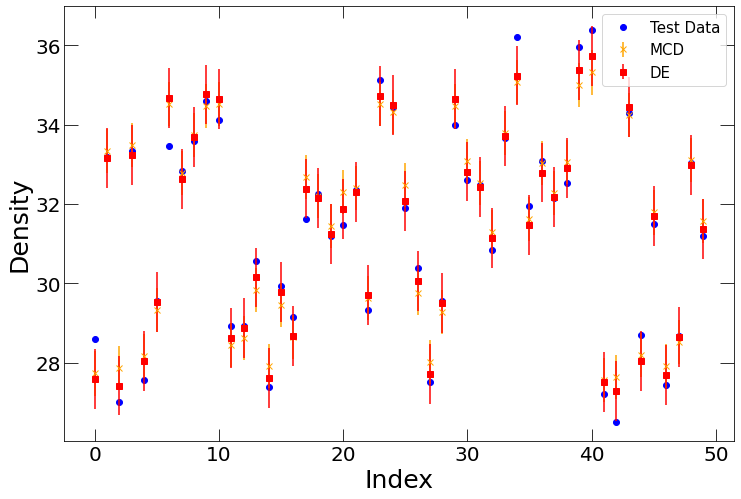

In [35]:
plt.figure(figsize=(12,8))

#-------------Test Data
plt.plot(y_test_actual[0:50], "ob", 
        label = "Test Data")

#-------------MCD
plt.errorbar(
    list(range(50)),
    Actual_predictions_mcd[0:50],
    yerr=(pd.DataFrame(pred_err_bars_mcd).T)[0][:50], fmt='x',
    color = "orange", label = "MCD"
)

#-------------DE
plt.errorbar(
    list(range(50)),
    Actual_predictions_de[0:50],
    yerr=(pd.DataFrame(pred_err_bars_de).T)[0][:50], fmt='s', #s,v,x
    color = "r", label = "DE"
)

#-------------Figure labels
plt.xlabel("Index")
plt.ylabel("Density")
plt.legend(fontsize=15)
plt.show()

Next, we plot a scatter plot of the predicted and actual values for the two models.

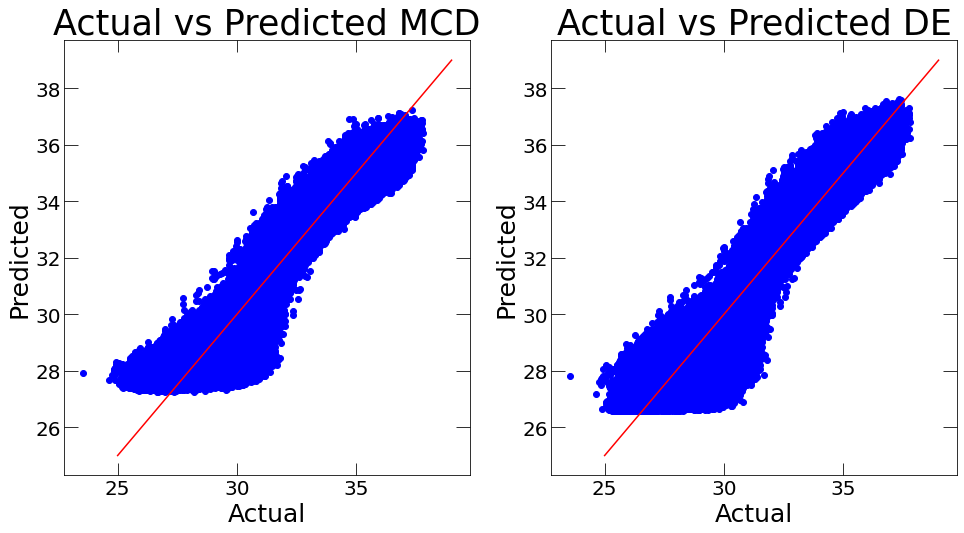

In [36]:
#-------------Actual vs predicted scatter plot (MCD)
plt.figure(figsize = (16,8))
plt.subplot(1, 2, 1)
xx = np.linspace(25, 39)
plt.plot(xx,xx, color = "red")
plt.scatter(y_test_actual, Actual_predictions_mcd, color="blue")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted MCD")

##########################################
##########################################
#-------------Actual vs predicted scatter plot (DE)
plt.subplot(1, 2, 2)
xx = np.linspace(25, 39)
plt.plot(xx,xx, color = "red")
plt.scatter(y_test_actual, Actual_predictions_de, color="blue")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted DE")
plt.show()

### Correlation plot

We expect to see a high positive correlation between the actual and predicted values.


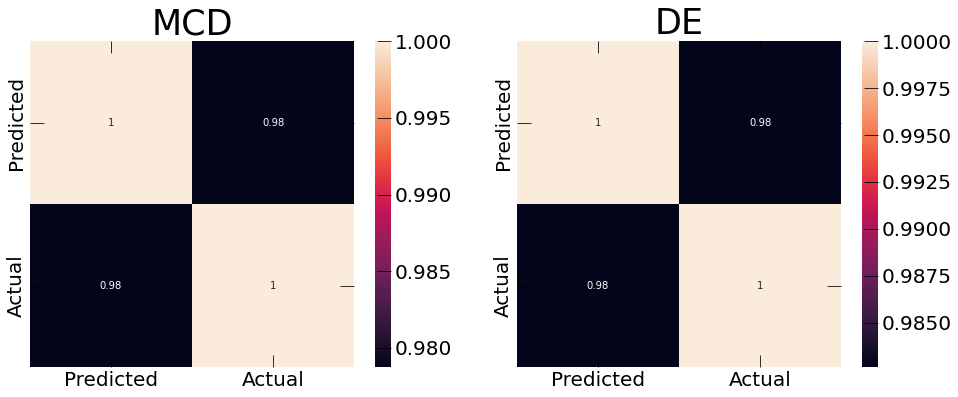

In [37]:
#-------------Correlation plot (MCD)
plt.figure(figsize = (16,6))
plt.subplot(1, 2, 1)
cor_mcd = pd.DataFrame(Actual_predictions_mcd).rename(columns = {0:"Predicted"})\
.join(pd.DataFrame(y_test_actual, columns = ['Actual']))

corrMatrix_mcd = cor_mcd.corr()
sns.heatmap(corrMatrix_mcd, annot=True)
plt.title("MCD")

############################################
############################################
#-------------Correlation plot (DE)
plt.subplot(1, 2, 2)
cor_de = pd.DataFrame(Actual_predictions_de).rename(columns = {0:"Predicted"})\
.join(pd.DataFrame(y_test_actual, columns = ['Actual']))

corrMatrix_de = cor_de.corr()
sns.heatmap(corrMatrix_de, annot=True)
plt.title("DE")
plt.show()

### Histogram of errors
Ideally, we expect the error on all predictions to be very close to zero. The more they are close to zero, the more our predictions are close to the actual values. We also expect the distribution of errors to be Gaussian. Thus, we expect the errors to be centered around around (i.e. have a mean of 0).


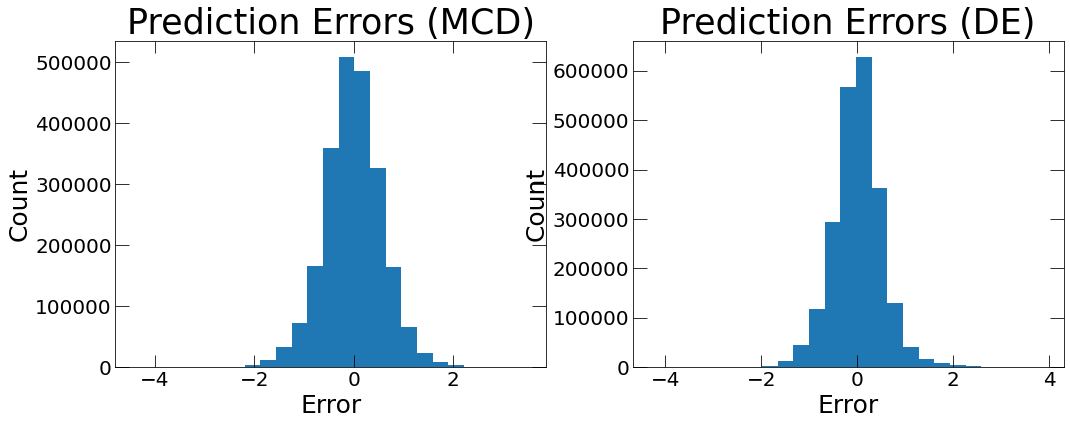

In [38]:
#-------------Histogram of errors (MCD)
plt.figure(figsize = (17,6))
plt.subplot(1, 2, 1)
# yy_mcd = np.abs(y_test_actual-Actual_predictions_mcd)
yy_mcd = y_test_actual-Actual_predictions_mcd
plt.hist(yy_mcd, bins = 25)
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Prediction Errors (MCD)")


#####################################
#####################################
#-------------Histogram of absolute errors (DE)
plt.subplot(1, 2, 2)
# yy_de = np.abs(y_test_actual-Actual_predictions_de)
yy_de = y_test_actual-Actual_predictions_de
plt.hist(yy_de, bins = 25)
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Prediction Errors (DE)")
plt.show()

### Measuring model goodness of fit

In [39]:
# Measuring Goodness of fit in test data (MCD)
print("Measuring Goodness of fit in test data (MCD):")
#-------------Adj. R2 
print('Adj. R2 Value MCD:', metrics\
      .r2_score(y_test_actual, Actual_predictions_mcd))

#-------------Mean Absolute Error
print("Mean Absolute Error:", metrics\
      .mean_absolute_error(Actual_predictions_mcd, y_test_actual))

#-------------Mean Squared Error
print("Mean Squared Error:", metrics\
      .mean_squared_error(Actual_predictions_mcd,y_test_actual))

#-------------Root Mean Squared Error
print("Root Mean Squared Error:", math\
      .sqrt(metrics.mean_squared_error(Actual_predictions_mcd,y_test_actual)))

#-------------Mean Absolute Percentage Error
print("Mean Absolute Percentage Error:", 
      np.mean(100*(np.abs(y_test_actual-Actual_predictions_mcd)/y_test_actual)))


#########################################################
#########################################################
#-------------Measuring Goodness of fit in test data (DE)
print("\nMeasuring Goodness of fit in test data (DE):")
#-------------Adj. R2 
print('Adj. R2 Value DE:', metrics\
      .r2_score(y_test_actual, Actual_predictions_de))

#-------------Mean Absolute Error
print("Mean Absolute Error:", metrics.\
      mean_absolute_error(Actual_predictions_de, y_test_actual))

#-------------Mean Squared Error
print("Mean Squared Error:", metrics\
      .mean_squared_error(Actual_predictions_de, y_test_actual))

#-------------Root Mean Squared Error
print("Root Mean Squared Error:", math\
      .sqrt(metrics.mean_squared_error(Actual_predictions_de, y_test_actual)))

#-------------Mean Absolute Percentage Error
print("Mean Absolute Percentage Error:", 
      np.mean(100*(np.abs(y_test_actual-Actual_predictions_de)/y_test_actual)))


Measuring Goodness of fit in test data (MCD):
Adj. R2 Value MCD: 0.9560456730438743
Mean Absolute Error: 0.4483058677066892
Mean Squared Error: 0.33657690033754173
Root Mean Squared Error: 0.5801524802476861
Mean Absolute Percentage Error: 1.4559015361947538

Measuring Goodness of fit in test data (DE):
Adj. R2 Value DE: 0.9655261190715035
Mean Absolute Error: 0.38529941525276973
Mean Squared Error: 0.2639811092341567
Root Mean Squared Error: 0.51379091976616
Mean Absolute Percentage Error: 1.2503900002567534


### Extracting test halo properties

Now, we will extract all the needed halo properties for our test halos from the `Rockstar_PH.csv` data set. These will be used in fitting the analytic models. 

In [40]:
#-------------First halo
Mvir = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][1] 
cvir = (rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][3])\
/(rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][5])
Rvir = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][3]
z = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo1_id].iloc[0][2] 
r = radial_bins_3d["r_mid"]/(1+z)

#-------------Second halo
Mvir2 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][1]
cvir2 = (rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][3])\
/(rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][5])
Rvir2 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][3]
z2 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[0]].iloc[0][2]
r2 = radial_bins_3d["r_mid"]/(1+z2)

#-------------Third halo
Mvir3 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][1]
cvir3 = (rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][3])\
/(rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][5])
Rvir3 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][3]
z3 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[1]].iloc[0][2]
r3 = radial_bins_3d["r_mid"]/(1+z3)

#-------------Fourth halo
Mvir4 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][1]
cvir4 = (rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][3])\
/(rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][5])
Rvir4 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][3]
z4 = rockstar_rs_z_final[rockstar_rs_z_final["id"] == halo_ids[2]].iloc[0][2]
r4 = radial_bins_3d["r_mid"]/(1+z4)

### Fitting analytic profile models

Now, we set cosmology for the analytic models. We also fit three analytic models to the test halos. They include NFW, Einasto, and DK14 density profiles. 

In [41]:
#Setting Cosmology.
params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.046, 'sigma8': 0.82, 'ns': 0.96}
cosmo = cosmology.setCosmology('my_cosmo', params)
print(cosmo)

#-------------First halo
p_dk14 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir, c = cvir, z = z, 
                                                   mdef = 'vir', outer_term_names = ['pl'])
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_einasto = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
rho_dk14 = p_dk14.density(r*1000)
rho_nfw = p_nfw.density(r*1000)
rho_einasto = p_einasto.density(r*1000)

#-------------Second halo
p_dk14_2 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir2, c = cvir2, z = z2, 
                                                     mdef = 'vir', outer_term_names = ['pl'])
p_nfw_2 = profile_nfw.NFWProfile(M = Mvir2, c = cvir2, z = z2, mdef = 'vir')
p_einasto_2 = profile_einasto.EinastoProfile(M = Mvir2, c = cvir2, z = z2, mdef = 'vir')
rho_dk14_2 = p_dk14_2.density(r2*1000)
rho_nfw_2 = p_nfw_2.density(r2*1000)
rho_einasto_2 = p_einasto_2.density(r2*1000)

#-------------Third halo
p_dk14_3 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir3, c = cvir3, z = z3, 
                                                     mdef = 'vir', outer_term_names = ['pl'])
p_nfw_3 = profile_nfw.NFWProfile(M = Mvir3, c = cvir3, z = z3, mdef = 'vir')
p_einasto_3 = profile_einasto.EinastoProfile(M = Mvir3, c = cvir3, z = z3, mdef = 'vir')
rho_dk14_3 = p_dk14_3.density(r3*1000)
rho_nfw_3 = p_nfw_3.density(r3*1000)
rho_einasto_3 = p_einasto_3.density(r3*1000)

#-------------Fourth halo
p_dk14_4 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir4, c = cvir4, z = z4, 
                                                     mdef = 'vir', outer_term_names = ['pl'])
p_nfw_4 = profile_nfw.NFWProfile(M = Mvir4, c = cvir4, z = z4, mdef = 'vir')
p_einasto_4 = profile_einasto.EinastoProfile(M = Mvir4, c = cvir4, z = z4, mdef = 'vir')
rho_dk14_4 = p_dk14_4.density(r4*1000)
rho_nfw_4 = p_nfw_4.density(r4*1000)
rho_einasto_4 = p_einasto_4.density(r4*1000)

Cosmology "my_cosmo" 
    flat = True, Om0 = 0.2860, Ode0 = 0.7139, Ob0 = 0.0460, H0 = 70.00, sigma8 = 0.8200, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


###  Plotting test halo density profiles

Below, we plot the actual density profile of the test halos against the predicted density profiles from the analytic models and the machine learning models.

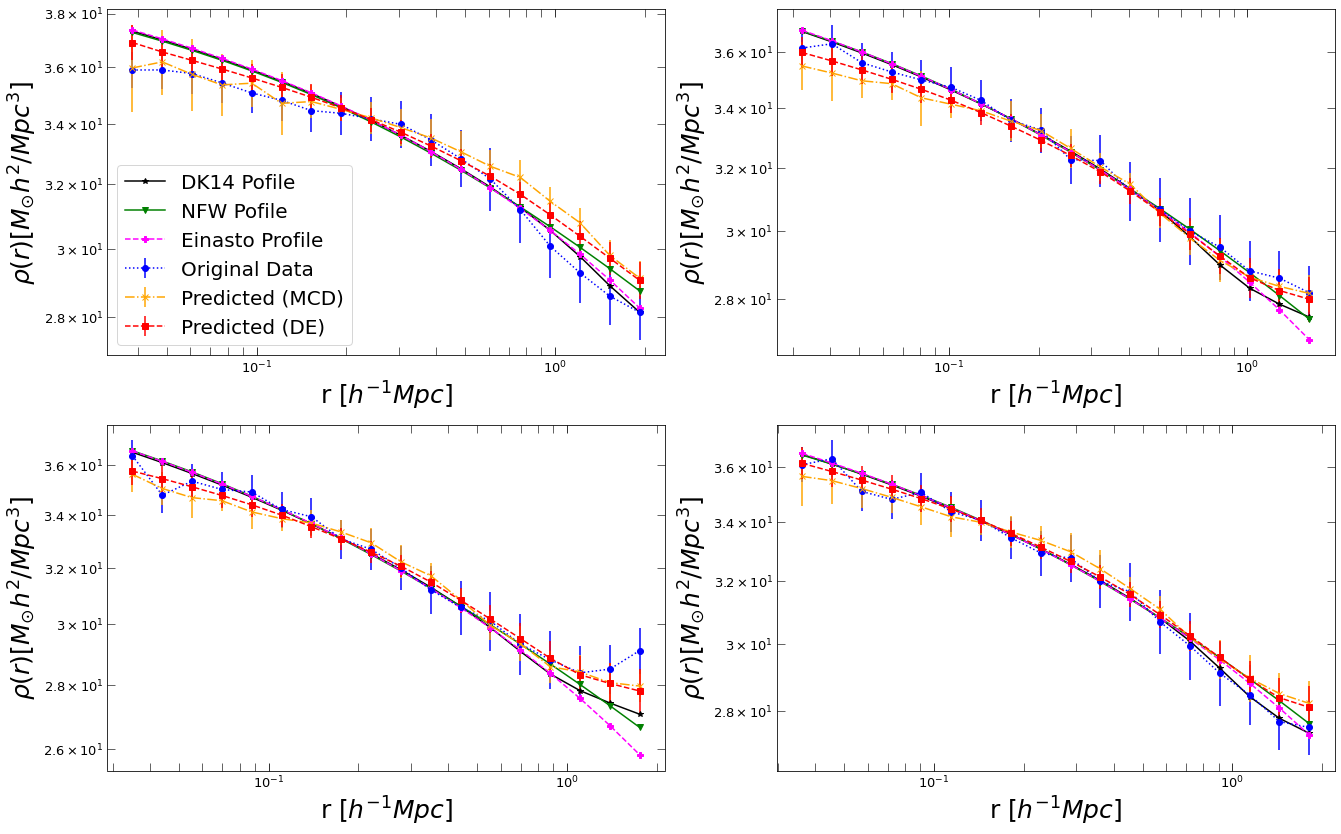

In [42]:
#Comparing plots: Visual comparison

########################
########################
#-------------First halo-------------#
plt.figure(figsize = (22,14))
plt.subplot(2, 2, 1)
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()


#-------------Original Data
plt.errorbar(
    r,
    y_test_halo1,
    yerr=actual_err_bars, fmt='o', linestyle='dotted', 
    label = "Original Data", color = "blue"
)


#-------------Predicted (MCD)
plt.errorbar(
    r,
    test_halo_pred1_mcd,
#     xerr=0.01,
    yerr=err_bars1_mcd, fmt='x', linestyle='dashdot', 
    label = "Predicted (MCD)", color = "orange"
)


#-------------Predicted (DE)
plt.errorbar(
    r,
    test_halo_pred1_de,
    yerr=err_bars1_de, fmt='s', linestyle='dashed', 
    label = "Predicted (DE)", color = "r"
)


#-------------Analytic density profiles
plt.plot(r, np.log(rho_dk14*1e9), '-', 
         label = 'DK14 Pofile', color = "black", marker="*") #DK14
plt.plot(r, np.log(rho_nfw*1e9), '-', 
         label = 'NFW Pofile', color = "green", marker="v") #NFW
plt.plot(r, np.log(rho_einasto*1e9), '--', 
         label = 'Einasto Profile', color = "magenta", marker="P") #Einasto
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=13, top = True, right = True)
plt.legend()


########################
########################
#-------Second halo-------------#
plt.subplot(2, 2, 2)
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()

#-------------Original data
plt.errorbar(
    r2,
    y_test_halo2,
    yerr=actual_err_bars, fmt='o', linestyle='dotted', 
    label = "Original Data", color = "blue"
)


#-------------Predicted (MCD)
plt.errorbar(
    r2,
    test_halo_pred2_mcd,
    yerr=err_bars2_mcd, fmt='x', linestyle='dashdot', 
    label = "Predicted (MCD)", color = "orange"
)


#-------------Predicted (DE)
plt.errorbar(
    r2,
    test_halo_pred2_de,
    yerr=err_bars2_de, fmt='s', linestyle='dashed', 
    label = "Predicted (DE)", color = "r"
)


#-------------Analytic density profiles
plt.plot(r2, np.log(rho_dk14_2*1e9), '-', 
         label = 'DK14 Pofile', color = "black", marker="*") #DK14
plt.plot(r2, np.log(rho_nfw_2*1e9), '-', 
         label = 'NFW Pofile', color = "green", marker="v") #NFW
plt.plot(r2, np.log(rho_einasto_2*1e9), '--', 
         label = 'Einasto Profile', color = "magenta", marker="P") #Einasto
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=13, top = True, right = True)


############################################################
############################################################
#-------Third halo-------------#
plt.subplot(2, 2, 3)
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()

#-------------Original data
plt.errorbar(
    r3,
    y_test_halo3,
    yerr=actual_err_bars, fmt='o', linestyle='dotted', 
    label = "Original Data", color = "blue"
)


#-------------Predicted (MCD)
plt.errorbar(
    r3,
    test_halo_pred3_mcd,
    yerr=err_bars3_mcd, fmt='x', linestyle='dashdot', 
    label = "Predicted (MCD)", color = "orange"
)


#-------------Predicted (DE)
plt.errorbar(
    r3,
    test_halo_pred3_de,
#     xerr=0.01,
    yerr=err_bars3_de, fmt='s', linestyle='dashed', 
    label = "Predicted (DE)", color = "r"
)


#-------------Analytic density profiles
plt.plot(r3, np.log(rho_dk14_3*1e9), '-', 
         label = 'DK14 Pofile', color = "black", marker="*") #DK14
plt.plot(r3, np.log(rho_nfw_3*1e9), '-', 
         label = 'NFW Pofile', color = "green", marker="v") #NFW
plt.plot(r3, np.log(rho_einasto_3*1e9), '--', 
         label = 'Einasto Profile', color = "magenta", marker="P") #Einasto
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=13, top = True, right = True)

############################################################
############################################################
#-------Fourth halo-------------#
plt.subplot(2, 2, 4)
plt.xlabel(r"r [$h^{-1}Mpc$]")
plt.ylabel(r"$\rho(r) [M_{\odot}h^2/Mpc^3]$")
plt.loglog()


#-------Original data
plt.errorbar(
    r4,
    y_test_halo4,
    yerr=actual_err_bars, fmt='o', linestyle='dotted', 
    label = "Original Data", color = "blue"
)


#-------------Predicted (MCD)
plt.errorbar(
    r4,
    test_halo_pred4_mcd,
    yerr=err_bars4_mcd, fmt='x', linestyle='dashdot',
    label = "Predicted (MCD)", color = "orange"
)


#-------------Predicted (DE)
plt.errorbar(
    r4,
    test_halo_pred4_de,
    yerr=err_bars4_de, fmt='s', linestyle='dashed', 
    label = "Predicted (DE)", color = "r"
)

#-------------Analytic density profiles
plt.plot(r4, np.log(rho_dk14_4*1e9), '-', 
         label = 'DK14 Pofile', color = "black", marker="*") #DK14
plt.plot(r4, np.log(rho_nfw_4*1e9), '-', 
         label = 'NFW Pofile', color = "green", marker="v") #NFW
plt.plot(r4, np.log(rho_einasto_4*1e9), '--', 
         label = 'Einasto Profile', color = "magenta", marker="P") #Einasto
plt.tick_params(axis="both", direction="in", length=8, which = "both", 
                labelsize=13, top = True, right = True)

plt.show()

<!-- We need criteria to measure whether our error bars are realistic. For instance, how do we tell if the error bars are too small or too big, or just ok? We adopt a chi-square measure given as:

$$chi-square = \frac{\sum_i^n \frac{(Y_i-\hat{Y}_i)^2}{e_i^2}}{df},$$

where:
* $Y_i$ - actual value of the $ith$ observation
* $\hat{Y}_i$ - the predicted value of the $ith$ observation
* $e_i$ - error bar of the ith prediction
* df: the degrees of freedom.


Ideally, we expect the chi-square measure to be close to 1. 

If:
* chi-square >> 1 $\implies$ error bar too small
* chi-square << 1 $\implies$ error bar too big -->



### Generalized MSE (Chi-square)

We need criteria to measure whether our error bars are realistic. For instance, how do we tell if the error bars are too small or too big, or just ok? We adopt a chi-square measure given as:

$$chi-square = \frac{\sum_i^n \frac{(Y_i-\hat{Y}_i)^2}{e_i^2}}{N - \Theta},$$

where:
* $Y_i$ - actual value of the $ith$ observation
* $\hat{Y}_i$ - the predicted value of the $ith$ observation
* $e_i$ - error bar of the ith prediction
* N - number of data points
* $\Theta$ - number of model parameters

NB: $N - \Theta$ = degrees of freedom


Ideally, we expect the chi-square measure to be close to 1. 

If:
* chi-square >> 1 $\implies$ error bar too small
* chi-square << 1 $\implies$ error bar too big


In [43]:
#-------------MCD
a_mcd=((y_test_actual - Actual_predictions_mcd)**2/pred_err_bars_mcd.ravel()**2).sum()
b_mcd=len(y_test)-model_mcd.count_params()*50
chi_sq_mcd = a_mcd/b_mcd
chi_sq_mcd

1.16616194523339

In [44]:
#-------------DE
a_de=((y_test_actual - Actual_predictions_de)**2/pred_err_bars_de.ravel()**2).sum()
b_de=len(y_test)-457*50
chi_sq_de = a_de/b_de
chi_sq_de

0.8501601522099409

### Computing mean squared error (MSE)
The MSE is given as:
$$MSE = \frac{1}{n}\sum_i^n\left(Y_i-\hat{Y}_i\right)^2$$

$Y_i$ and $\hat{Y}_i$ are the same as in the definition of chi-square above. The MSE is used to measure the average squared between predictions and actual values. Thus, it measures how close predictions are to the actual values. The smaller the MSE, the preferred. Note that the MSE is a loss function. A loss function measures the discrepancy between a model's prediction vs the expected/true outcome.

In [45]:
X_test_actual = pd.DataFrame(X_test_actual)
X_test_actual.columns = Final_DF_Log_reshuffle.columns

X_test_actual["id"] = X_test_actual["id"].astype("int64")
X_test_actual.head()

,PeakHeight,Density,rmid_Rvir,Mvir_Msun.h,Rvir_Mpc.h,r_mid,rs,z_orig,Density_orig,PeakHeight_orig,r_mid_phys,id,index
3003983,0.621846,28.607409,1.386738,2.225000e+13,0.409307,2.673750,0.189357,0.632371,2.654849e+12,1.862363,1.637955,5103766,3003983
452290,0.806010,33.182305,-1.118255,8.754000e+13,0.708003,0.336606,0.091811,0.454584,2.575681e+14,2.238957,0.231410,32852888,452290
9918807,0.352009,27.014581,1.144630,1.390000e+13,0.425979,1.687020,0.075175,0.260741,5.398626e+11,1.421922,1.338118,2491817,9918807
10662472,0.326572,33.339725,-1.341455,1.209000e+13,0.406916,0.134005,0.076472,0.259512,3.014802e+14,1.386208,0.106394,5283482,10662472
11076071,0.391125,27.573257,0.741307,1.056000e+13,0.353443,1.064440,0.072525,0.435013,9.438724e+11,1.478644,0.741763,17203553,11076071


In [46]:
# X_test_actual.to_csv("Data/X_test_actual_new.csv", index=False)
# X_test_actual = pd.read_csv("Data/X_test_actual.csv")
# X_test_actual.head()

### NFW and Einasto predictions on the whole test set

Here we use the NFW and Einasto predictions on the entire test set.

In [47]:
%%time

Mvir = X_test_actual.loc[:, "Mvir_Msun.h"]
Rvir = X_test_actual.loc[:, "Rvir_Mpc.h"]
rs = X_test_actual.loc[:, "rs"]
z_orig = X_test_actual.loc[:, "z_orig"]
r_mid = X_test_actual.loc[:, "r_mid_phys"]
cvir = Rvir/rs
p_nfw_5 = profile_nfw.NFWProfile(M = Mvir, c = cvir, 
                                 z = z_orig, mdef = 'vir')

p_einasto_5 = profile_einasto.EinastoProfile(M = Mvir, c = cvir, 
                                             z = z_orig, mdef = 'vir')

rho_nfw_5 = p_nfw_5.density(r_mid*1000)*1e9
rho_einasto_5 = p_einasto_5.density(r_mid*1000)*1e9

CPU times: user 5.27 s, sys: 319 ms, total: 5.59 s
Wall time: 2.3 s


### DK14 predictions on the whole test set

Unlike the NFW and Einasto profiles, the DK14 profile does not accept an array at a time. This means we have to loop over the array and feed the values into the function one after the other. This takes a lot of computation. This loop takes about 14.5 hours to complete, given about 2.2 million data points in the test set. For this reason, we parallelize the code to be able to run faster. We, first of all, define a function that calibrates the DK14 profile. The function saves the squared errors between the predicted and actual densities to a `.npy` file.


In [48]:
def diemer_14(split_chunk):
    '''
    This functions takes a chunk of data, fits the DK14 profile  to 
    compute the densities, and then returns the squared difference between 
    the DK14 predictions and the actual densities.
    #----------Argument/Input:
        split_chunk: A chunk of data set. Variables in this data set is to 
                     be used to calibrate the densities.
    #----------Output(s):
        Saves the squared difference between the DK14 predictions and the actual 
        densities into a .npy file.
    '''
    DK14_Density = []
    # #-------------Setting Cosmology.
    # params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.046, 'sigma8': 0.82, 'ns': 0.96}
    # cosmo = cosmology.setCosmology('my_cosmo', params)
    for i in range(len(split_chunk)):
        '''
        #-------------Paramters
        Mvir: virial mass of halo
        Rvir: virial radius
        rs: virial radius
        z_orig: redshift of the halo
        Density: The actual density of the halo
        '''
        Mvir, Rvir, rs, z_orig, r_mid, Density = split_chunk[i]
        p_dk14_51 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir, 
                                                              c = Rvir/rs, 
                                                              z = z_orig, mdef = 'vir', 
                                                              outer_term_names = ['pl'])
        rho_dk14_5 = p_dk14_51.density(r_mid*1000)*1e9
        squared_diff = (Density-np.log(rho_dk14_5))**2
        DK14_Density.append(squared_diff)
    #-------------Saving results to a .npy file
    filename = f"{datetime.today().isoformat()}.npy"
    f = open(f"DK14_mse_2/{filename}", "wb")
    np.save(f, DK14_Density)
    f.close()


Next, we parallelize the code using Python multiprocessing. The code below takes a long time to run on the entire test set. For it to run in a notebook, we usually run it on a small sample of the data set. This time we will not run this cell because a Python job was submitted to run on the entire test set and the files are stored in a folder. 

In [49]:
# %%time

# import os
# import csv
# import multiprocessing
# from datetime import datetime
# from multiprocessing import Pool

# #-------------Delete all files ending with .npy in this directory
# mydir = "DK14_mse_2/"
# filelist = [f for f in os.listdir(mydir) if f.endswith(".npy")]

# for f in filelist:
#     os.remove(os.path.join(mydir, f))

# #-------------Number of processes
# processors = multiprocessing.cpu_count()
# dk14data = X_test_actual[["Mvir_Msun.h", "Rvir_Mpc.h", "rs", "z_orig", 
#                           "r_mid_phys", "Density"]].sample(n=2000).values#.reshape(1,-1)
# # dk14data = X_test_actual[["Mvir_Msun.h", "Rvir_Mpc.h", "rs", "z_orig", 
# #                           "r_mid_phys", "Density"]].values#.reshape(1,-1)

# #-------------Splitting data. Number of chunks equals the number of processes available
# split_data = np.array_split(dk14data, processors)

# #-------------Parallelising code using multiprocessing
# if __name__ == '__main__':
#     '''
#     Each chunk of data is set to run on a different processors. 
#     Each processor stores the results in a separate .npy file. 
#     The files are named using time stamps.
#     '''
#     with Pool(processes=processors) as p:
#     # with Pool() as p: #this line equally works as the line above
#         p.map(func = diemer_14, iterable = split_data)

The codes in the two cells above were written as a Python script. And a job was submitted to run the script on the r2 cluster. The scripts used to submit the job are available on GitHub. The result from each process is stored in a separate `.npy` file. All the results are saved in a single folder named `DK14_mse`.

Next, we load all the files into a single `NumPy` array. We get the MSE by computing the mean of this array. 

In [50]:
import glob
#-------------Reading all files from directory
# DK14_mse_files = sorted(glob.glob("DK14_mse/20*")) #this code equally works as the next line below
DK14_mse_files = sorted(glob.glob("DK14_mse/*.npy"))
all_arrays = []
all_arrays2 = np.empty(shape = 0)

for file in DK14_mse_files:
    all_arrays.append(np.load(file))
all_arrays = np.array(all_arrays).reshape(1,-1)[0]

for i in all_arrays:
    all_arrays2 = np.concatenate((all_arrays2, i), axis=0) 
all_arrays2 = all_arrays2.reshape(1,-1)[0].reshape(1,-1)[0]
# print(len(all_arrays2))
np.mean(all_arrays2)

/tmp/ipykernel_6279/2999010243.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_arrays = np.array(all_arrays).reshape(1,-1)[0]


0.35701618400896645

### The MSE's

In [51]:
#-------------Computing MSE's
NFW_mse = ((y_test_actual - np.array(np.log(rho_nfw_5)))**2).sum()/len(y_test)
Einasto_mse = ((y_test_actual - np.array(np.log(rho_einasto_5)))**2).sum()/len(y_test)
mse_mcd = ((y_test_actual - Actual_predictions_mcd)**2).sum()/len(y_test)
mse_de = ((y_test_actual - Actual_predictions_de)**2).sum()/len(y_test)

#-------------Print them
print(f"MSE for DK14 Model is: {np.mean(all_arrays2)}")
print(f"MSE for Einasto Profile is: {Einasto_mse}")
print(f"MSE for NFW Profile is: {NFW_mse}")
print(f"MSE for MCD Model is: {mse_mcd}")
print(f"MSE for DE Model is: {mse_de}")


MSE for DK14 Model is: 0.35701618400896645
MSE for Einasto Profile is: 0.5159684527706604
MSE for NFW Profile is: 0.3805974410083638
MSE for MCD Model is: 0.33657690033754173
MSE for DE Model is: 0.2639811092341567


# THE END